Upload locally generated edax eval files before running this notebook

In [66]:
import pandas as pd
import numpy as np
def extract_scores(solution_file):
    scores = []
    with open(solution_file, 'r') as file:
        # Skip the header and the line below it
        next(file)
        next(file)

        for line in file:
            if not line.strip():
                continue  # Skip any empty lines
            parts = line.split('|')[1].split()
            depth = int(parts[0].strip())
            score = parts[1].strip()

            # Check if the depth is 16, then extract the score
            # assert(depth == 16)
            scores.append(int(score))

    return np.array(scores)

In [119]:
scores_16_16 = extract_scores("eval_16_16_100k_20240502.txt")
scores_0_16 = extract_scores("eval_0_16_100k_20240502.txt")
scores_0_11 = extract_scores("eval_0_11_100k_20240508.txt")
scores_11_11 = extract_scores("eval_11_11_100k_20240508.txt")

In [69]:
df = pd.DataFrame(scores_0, columns=['scores_0'])
df['scores_16'] = scores_16
df

,scores_0,scores_16
0,22,10
1,13,0
2,4,4
3,-5,2
4,1,-2
...,...,...
99995,-1,4
99996,-16,-4
99997,-9,-20
99998,19,30


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


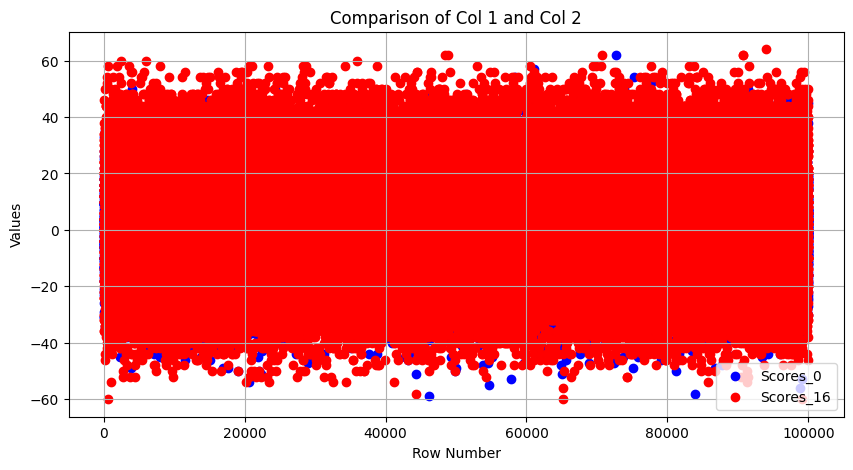

In [70]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 5))  # Set the figure size
plt.scatter(df.index, df['scores_0'], color='b', label='Scores_0')  # Plot first column
plt.scatter(df.index, df['scores_16'], color='r', label='Scores_16')  # Plot second column
plt.title('Comparison of Col 1 and Col 2')  # Title of the plot
plt.xlabel('Row Number')  # Label for the x-axis
plt.ylabel('Values')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Add grid
plt.show()  # Show the plot

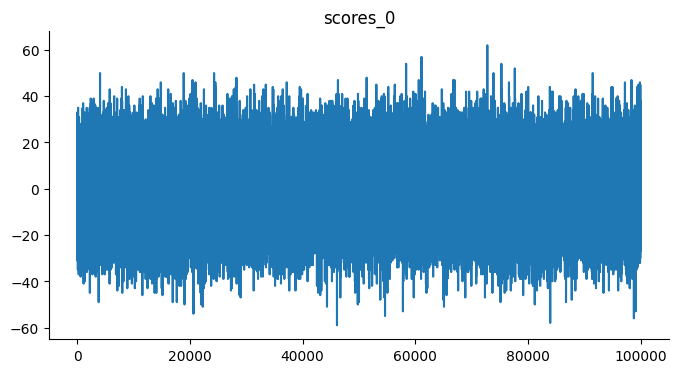

In [71]:
# @title scores_0

from matplotlib import pyplot as plt
df['scores_0'].plot(kind='line', figsize=(8, 4), title='scores_0')
plt.gca().spines[['top', 'right']].set_visible(False)

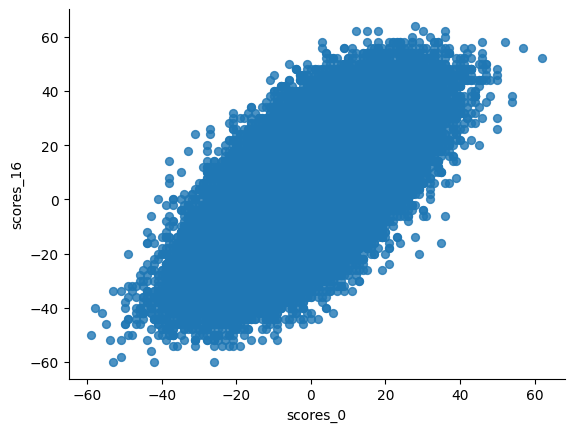

In [72]:
# @title scores_0 vs scores_16

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='scores_0', y='scores_16', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

From the above plot, We care more about the signs of prediction vs result.

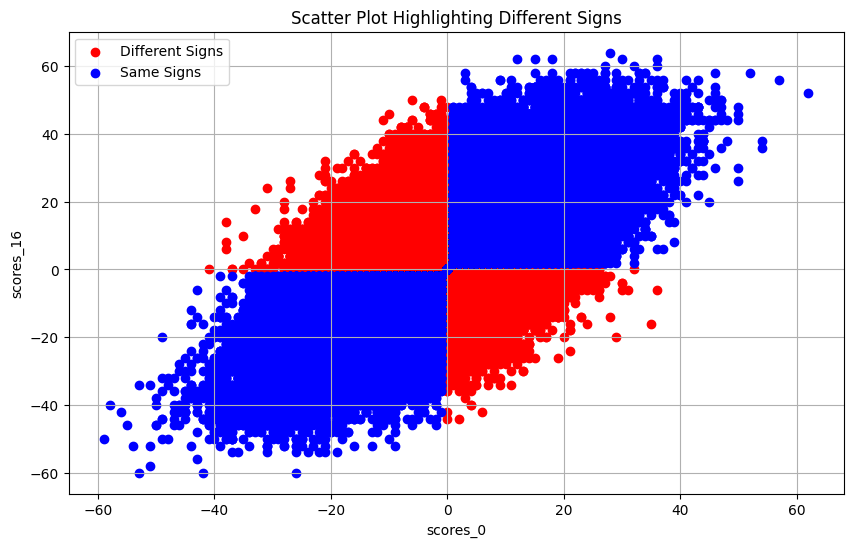

In [73]:
# Create a condition array where True denotes different signs between x and y
different_signs = np.sign(scores_0) != np.sign(scores_16)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(scores_0[different_signs], scores_16[different_signs], color='red', label='Different Signs')
plt.scatter(scores_0[~different_signs], scores_16[~different_signs], color='blue', label='Same Signs')
plt.xlabel('scores_0')
plt.ylabel('scores_16')
plt.title('Scatter Plot Highlighting Different Signs')
plt.legend()
plt.grid(True)
plt.show()

I suspect some points overlap. Using a small sample, overlapping can significantly affect the perceived data distribution, and difference between the above and following graph would manifest.

In [74]:
np.sum(different_signs)

30499

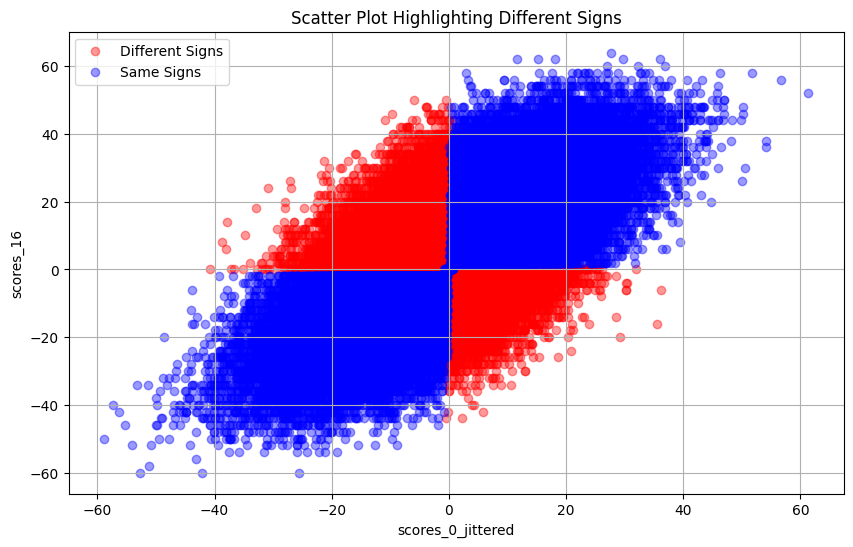

In [75]:
# Jittering the data
noise_scale = 0.3  # Adjust this scale to your data range
scores_0_jittered = scores_0 + np.random.normal(0, noise_scale, scores_0.shape)
scores_16_jittered = scores_16 + np.random.normal(0, noise_scale, scores_16.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(scores_0_jittered[different_signs], scores_16[different_signs], alpha=0.4, color='red', label='Different Signs')
plt.scatter(scores_0_jittered[~different_signs], scores_16[~different_signs], alpha=0.4, color='blue', label='Same Signs')
plt.xlabel('scores_0_jittered')
plt.ylabel('scores_16')
plt.title('Scatter Plot Highlighting Different Signs')
plt.legend()
plt.grid(True)
plt.show()

# Train a model better at predicting positivity


The result from Edax eval shows an accuracy of 71%. To significantly surpass Edax we target a model with >80% accuracy.

## Data Preperation

Generate data & label:

```
X, X_train, X_test # data, formatted as a len-64 ternary string of 0,1,-1. 0 -> empty_square, 1 -> X_square, -1 -> O_square

y, y_train, y_test # label, transformed from score (difference in square) to 3 positivities
```



In [76]:
def extract_states(test_obf_file):
    states = []
    mapping = {'X': 1, '-': 0, 'O': -1}
    with open(test_obf_file, 'r') as file:
        for line in file:
            obf = line.split()[0]
            new_state = np.array([mapping[char] for char in obf])
            print(new_state)
            states.append(new_state)
    return np.array(states)

Streaming output truncated to the last 5000 lines.
  0  1  1  0 -1 -1  0  1 -1  0 -1  0  0  1 -1 -1  1  0 -1  1  1 -1  0  1
  1 -1  1  1 -1 -1  0  1  1  1 -1  1  1  1  0 -1]
[-1 -1 -1 -1 -1  0  1  0  0  1  0  0 -1 -1  0  1 -1  1  1  0  0 -1 -1 -1
  0  1 -1  0 -1  1  1  1  1  1  1  1 -1  1 -1  0 -1 -1 -1 -1  0 -1  1  1
  1 -1  0  1 -1  1  0  1  1 -1 -1 -1  1  0  1  0]
[ 1 -1 -1 -1 -1  0  1  1  1  1  1 -1 -1  0 -1  1  1  1  1 -1  0 -1  1  0
  1  0 -1  1  0  0  0  0 -1  0 -1  0  1  1  0  1  1  1  1 -1 -1  0  1 -1
  1  1  1  0  0 -1  1  1  1 -1 -1 -1 -1 -1  0 -1]
[-1 -1  0 -1  1  0  1  0 -1 -1  0  1  1  1  0  1  1  0 -1  1  0  1  1  0
 -1 -1  0  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1  1 -1  1  1 -1  0
  1  1  0  0  0 -1 -1  0  1 -1  1  0  1 -1  1  0]
[-1  0  1  1 -1  1  1  1 -1 -1 -1  0  1  0  1  0  0  0 -1  0 -1  1  0  1
  0  0  1 -1  0 -1  1 -1  1  1  1  1  1  1  1  1  1 -1  0  1 -1 -1 -1  0
  1  1  0  0  1 -1  1  1  1 -1  1 -1 -1  0  1  1]
[ 0  0  1 -1  1  1 -1  0  1  0  0 -1  0  1

In [78]:
def transform_to_positivity(arr):
    positivity_array = np.zeros_like(arr, dtype=np.int16)
    positivity_array[arr > 0] = 1
    positivity_array[arr < 0] = -1
    return positivity_array

array([ 1,  0,  1, ..., -1,  1, -1], dtype=int16)

In [110]:
from sklearn.model_selection import train_test_split

X = extract_states("test_obf_16_100k_20240502")
transformed_scores_16 = transform_to_positivity(scores_16)
X_train, X_test, y_train, y_test = train_test_split(X, transformed_scores_16, test_size=0.2)


## FC model

Transform y to catagorical


In [111]:
y_train += 1
y_test += 1

In [114]:
y_test

array([2, 0, 0, ..., 0, 0, 0], dtype=int16)

### Modeling

In [112]:
# Import necessary libraries
import numpy as np
import tensorflow as tf

# Define your fully connected neural network model architecture
def create_fc_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Load your dataset and preprocess it
# X_train, y_train, X_test, y_test = load_and_preprocess_data()

# Define your model hyperparameters
input_shape = (64,)  # Input shape of your data (for flattened input)
num_classes = 3  # Number of classes in your dataset
learning_rate = 0.001
batch_size = 32
epochs = 100

# Create an instance of your model
model = create_fc_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [113]:
# Report loss & Acc for epoch 0 as it's not reported by model.fit
initial_training_loss, initial_training_accuracy = model.evaluate(X_train, y_train)
initial_testing_loss, initial_testing_accuracy = model.evaluate(X_test, y_test)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Optionally, save the trained model
# model.save('my_fc_model.h5')

625/625 [==============================] - 1s 2ms/step - loss: 1.1511 - accuracy: 0.2096
Epoch 1/100
2500/2500 [==============================] - 11s 4ms/step - loss: 0.7531 - accuracy: 0.6503 - val_loss: 0.7396 - val_accuracy: 0.6594
Epoch 2/100
2500/2500 [==============================] - 14s 6ms/step - loss: 0.7312 - accuracy: 0.6668 - val_loss: 0.7336 - val_accuracy: 0.6632
Epoch 3/100
2500/2500 [==============================] - 11s 4ms/step - loss: 0.7270 - accuracy: 0.6701 - val_loss: 0.7321 - val_accuracy: 0.6633
Epoch 4/100
2500/2500 [==============================] - 9s 3ms/step - loss: 0.7235 - accuracy: 0.6720 - val_loss: 0.7386 - val_accuracy: 0.6642
Epoch 5/100
2500/2500 [==============================] - 10s 4ms/step - loss: 0.7207 - accuracy: 0.6728 - val_loss: 0.7406 - val_accuracy: 0.6617
Epoch 6/100
2500/2500 [==============================] - 12s 5ms/step - loss: 0.7180 - accuracy: 0.6753 - val_loss: 0.7331 - val_accuracy: 0.6639
Epoch 7/100
2500/2500 [=============

In [115]:
# Optionally, save the trained model
model.save('FC_128_128_64_64_epoch100.keras')

### Result

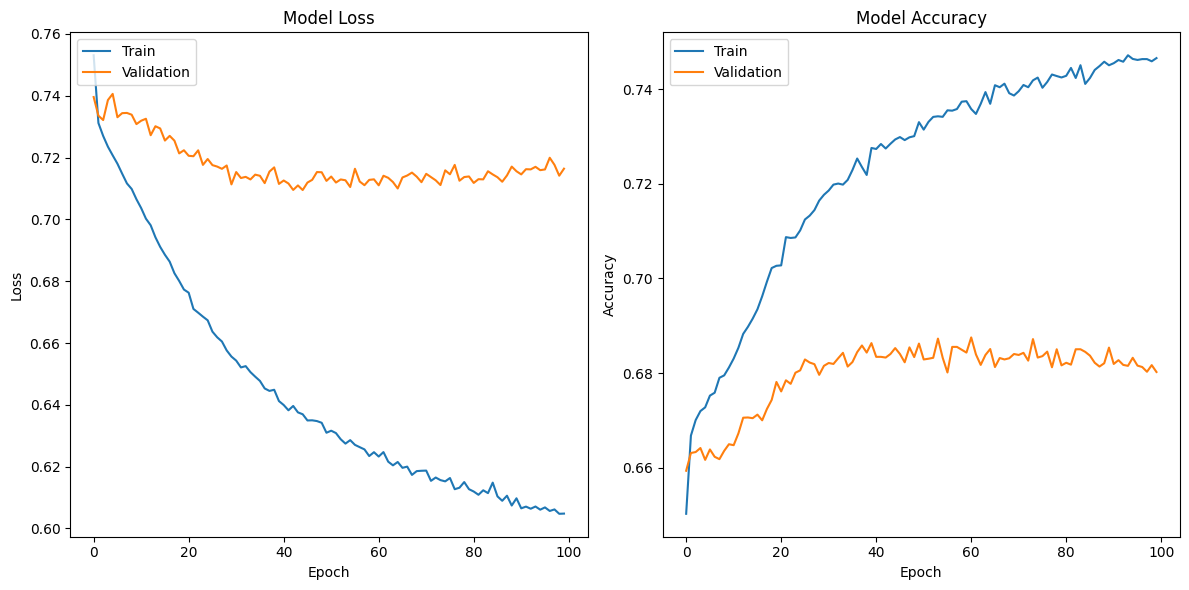

In [116]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Evaluate model on other game stages

#### 11 squares

In [120]:
X = extract_states("test_obf_11_100k_20240508")

Streaming output truncated to the last 5000 lines.
 -1 -1 -1  0  1  0  1  1  1 -1 -1 -1  1 -1  1 -1  0 -1 -1 -1 -1  0  1  1
 -1  1 -1 -1  1 -1  0 -1 -1  1  1 -1  0 -1  1  1]
[-1  0 -1 -1  1 -1  0 -1 -1  0  0  1 -1  1  0 -1 -1 -1 -1  0  0  1 -1  1
  0  1 -1 -1  1 -1  1 -1  0 -1  1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1  1
 -1  1  1  0  1  1 -1  1  1 -1 -1 -1  0 -1  1 -1]
[ 1 -1 -1  1 -1  1 -1 -1 -1  1 -1  0 -1  0  1  0  0 -1  1 -1  1  1 -1  1
 -1  1  1 -1  1  0 -1  1  0  1 -1 -1  0  1  1  0  1  1 -1  0 -1  1  1  1
  1 -1  0 -1  1 -1  1 -1 -1  1 -1 -1 -1  1  0  1]
[-1  1  1  0 -1  1 -1 -1  1 -1 -1  1 -1  1 -1  0  1 -1  1 -1  0  1  1  0
 -1  1  1 -1  0 -1 -1  0 -1  1  0 -1 -1  1  1 -1 -1  0 -1 -1 -1  1  0 -1
 -1  1  1 -1  0 -1  1 -1 -1 -1 -1 -1 -1  0  1 -1]
[ 1 -1  1 -1 -1 -1  1 -1  0 -1 -1 -1  0 -1 -1  1  1  1  1  0  1  1  1  1
  1 -1  1  1  1  0  1  0  1  1  1 -1  1  0 -1 -1  1  1  1  1  0 -1  1  1
  1  0 -1  1 -1  1  1  0  0 -1 -1 -1  1  1  1  0]
[-1 -1  1 -1  1  1 -1  1  1  1 -1  0  0 -1

In [127]:
transformed_scores_11 = transform_to_positivity(scores_11_11)
transformed_scores_11 += 1
model.evaluate(X, transformed_scores_11)

3125/3125 [==============================] - 7s 2ms/step - loss: 0.7735 - accuracy: 0.6513


[0.7734991312026978, 0.6513299942016602]

## CNN model